# Customer Segmentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("3_Customer_Segmentation.csv", encoding="latin1")
df.head(2)  

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
df.isnull().sum()
df = df.dropna(subset=["CustomerID"])
df["Description"] = df["Description"].fillna("Unknown Product")
df["CustomerID"] = df["CustomerID"].astype(int)

df["Total_Price"] = df["Quantity"] * df["UnitPrice"]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format="mixed")
df["Month"] = df["InvoiceDate"].dt.to_period("M")

snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

In [6]:
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "Total_Price": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,2,0.00
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40
...,...,...,...
18280,278,1,180.60
18281,181,1,80.82
18282,8,3,176.60


In [7]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
rfm_scaled

array([[ 2.32202285, -0.32936215, -0.23100099],
       [-0.89373323,  0.20610242,  0.29343167],
       [-0.1691956 , -0.11517632, -0.01231622],
       ...,
       [-0.83418219, -0.22226923, -0.20951263],
       [-0.87388289,  1.16993863,  0.02390005],
       [-0.48680114, -0.22226923, -0.00744423]], shape=(4372, 3))

In [8]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

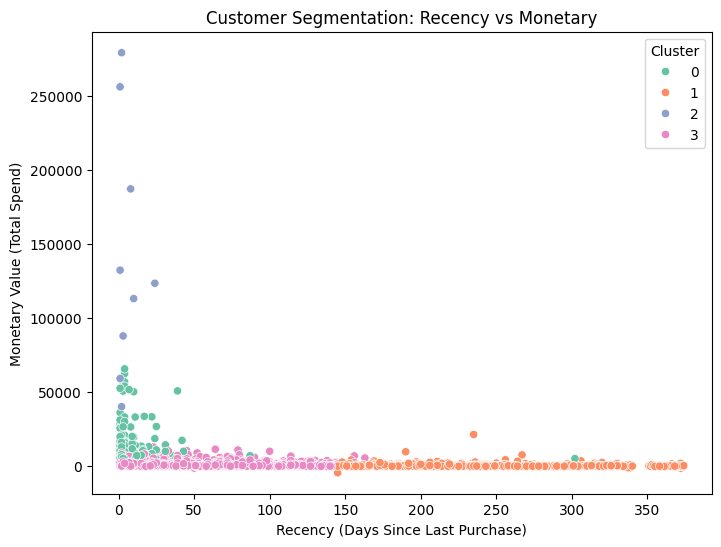

In [9]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm,
    x="Recency",
    y="Monetary",
    hue="Cluster",
    palette="Set2"
)

plt.title("Customer Segmentation: Recency vs Monetary")
plt.xlabel("Recency (Days Since Last Purchase)")
plt.ylabel("Monetary Value (Total Spend)")
plt.legend(title="Cluster")
plt.show()

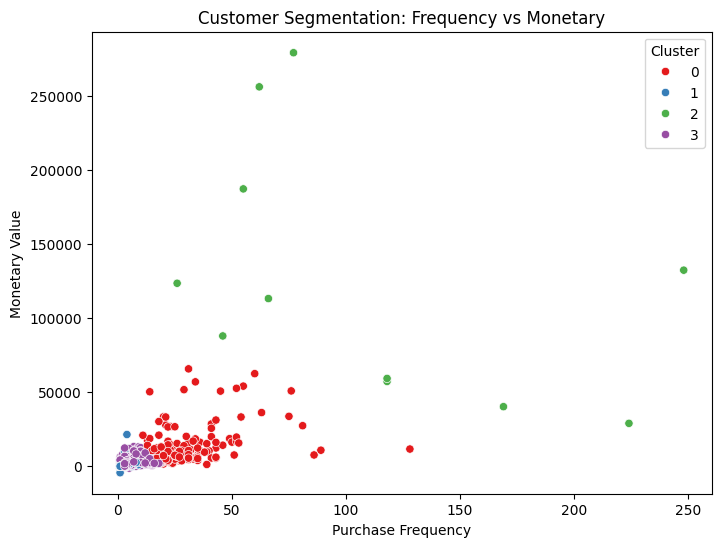

In [10]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm,
    x="Frequency",
    y="Monetary",
    hue="Cluster",
    palette="Set1"
)

plt.title("Customer Segmentation: Frequency vs Monetary")
plt.xlabel("Purchase Frequency")
plt.ylabel("Monetary Value")
plt.show()

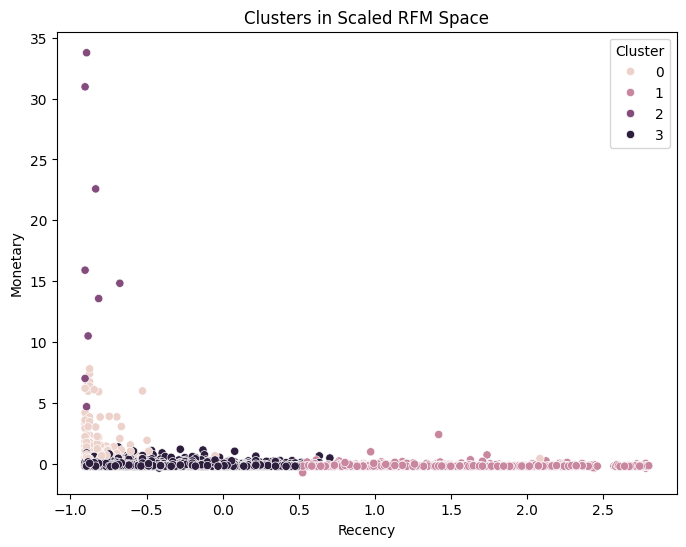

In [11]:
rfm_scaled_df = pd.DataFrame(
    rfm_scaled,
    columns=["Recency", "Frequency", "Monetary"]
)
rfm_scaled_df["Cluster"] = rfm["Cluster"].values

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm_scaled_df,
    x="Recency",
    y="Monetary",
    hue="Cluster"
)

plt.title("Clusters in Scaled RFM Space")
plt.show()

## Business Insights
- Cluster 0: High-value loyal customers → Retention programs
- Cluster 1: Low-frequency customers → Upselling campaigns
- Cluster 2: At-risk customers → Re-engagement offers
- Cluster 3: Inactive customers → Churn prevention